This is the notebook where we will do our data analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
knowledge_train <- read_excel("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", "Training_Data", range = "A1:F259")

#renaming the variable "very_low" to "Very Low" in order to facilitate data analysis with test data
knowledge_train$UNS <- recode(knowledge_train$UNS,
                                      "very_low" = "Very Low")
knowledge_train

knowledge_test <- read_excel("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", "Test_Data", range = "A1:F146")
knowledge_test

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


Some information about this dataset:
This dataset gives us insight into a person's degree of studying, including time,

STG (The degree of study time for goal object materails),
SCG (The degree of repetition number of user for goal object materails)
STR (The degree of study time of user for related objects with goal object)
LPR (The exam performance of user for related objects with goal object)
PEG (The exam performance of user for goal objects)
UNS (The knowledge level of user)

In [3]:
knowledge_train <- mutate(knowledge_train, class = as_factor(UNS)) |>
select(STG, SCG, PEG, class) 
knowledge_train
knowledge_test <- mutate(knowledge_test, class = as_factor(UNS)) |>
select(STG, SCG, PEG, class)
knowledge_test

STG,SCG,PEG,class
<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,Very Low
0.08,0.08,0.90,High
0.06,0.06,0.33,Low
⋮,⋮,⋮,⋮
0.54,0.82,0.77,High
0.50,0.75,0.26,Middle
0.66,0.90,0.74,High


STG,SCG,PEG,class
<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.05,Very Low
0.05,0.05,0.14,Low
0.08,0.18,0.85,High
⋮,⋮,⋮,⋮
0.56,0.60,0.32,Low
0.66,0.68,0.57,Middle
0.68,0.64,0.24,Middle


In [4]:
knowledge_train <- knowledge_train[order(knowledge_train$class),]
knowledge_train
knowledge_test <- knowledge_test[order(knowledge_test$class),]
knowledge_test


STG,SCG,PEG,class
<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,Very Low
0.15,0.02,0.01,Very Low
0.05,0.07,0.05,Very Low
⋮,⋮,⋮,⋮
0.56,0.60,0.50,Middle
0.78,0.61,0.60,Middle
0.50,0.75,0.26,Middle


STG,SCG,PEG,class
<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.05,Very Low
0.16,0.25,0.07,Very Low
0.18,0.26,0.04,Very Low
⋮,⋮,⋮,⋮
0.68,0.43,0.55,Middle
0.66,0.68,0.57,Middle
0.68,0.64,0.24,Middle


Our goal is to predict the class using STG, SCG and PEG.
The different possible classes are:
- very low
- low
- middle
- high

In [5]:
knowledge_proportions <- knowledge_train |>
                      group_by(class) |>
                      summarize(count = n()) |>
                      mutate(percent = 100*count/nrow(knowledge_train))
knowledge_proportions


class,count,percent
<fct>,<int>,<dbl>
Very Low,24,9.302326
High,63,24.418605
Low,83,32.170543
Middle,88,34.108527


@chantal describe the problem with this - there is not equal number of classes meaning data will be biased towards variables like middle. or maybe this is reflective of the overall population? 

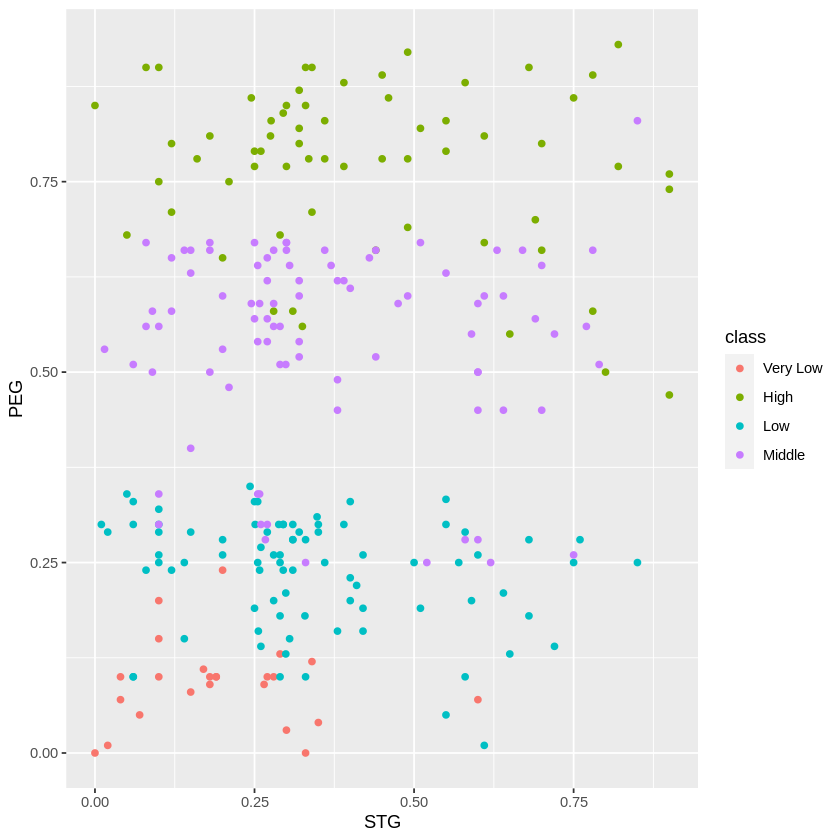

In [6]:
#visualizing initial plot to see which variable has highest influence
initial_plot <- ggplot(knowledge_train, aes(x= SCG, y= PEG, colour = class)) + 
                      geom_point() +
                      xlab("STG") +
                      ylab("PEG")
initial_plot

In [7]:
#creating the recipe

knowledge_recipe <- recipe(class ~ STG + PEG + SCG, data = knowledge_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
knowledge_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [8]:
#Trianing the classifier

#model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")

#fitting the data to build classifier
knn_fit <- workflow() |>
  add_recipe(knowledge_recipe) |>
  add_model(knn_spec) |>
  fit(data = knowledge_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2093023
Best kernel: rectangular
Best k: 5

In [15]:
#Predict the data using the test 
knowledge_test_predictions <- predict(knn_fit, knowledge_test) |>
  bind_cols(knowledge_test) 

# knowledge_test_predictions <- knowledge_test_predictions[order(knowledge_test_predictions$.pred_class),]
knowledge_test_predictions

.pred_class,STG,SCG,PEG,class
<fct>,<dbl>,<dbl>,<dbl>,<fct>
Very Low,0.00,0.10,0.05,Very Low
Very Low,0.16,0.25,0.07,Very Low
Very Low,0.18,0.26,0.04,Very Low
⋮,⋮,⋮,⋮,⋮
Middle,0.68,0.15,0.60,Middle
Middle,0.68,0.43,0.55,Middle
Middle,0.66,0.68,0.57,Middle


In [18]:
#accessing the quality of our model
knowledge_test_predictions |>
  metrics(truth = class, estimate = .pred_class) |>
  filter(.metric == "accuracy")

ERROR: [1m[33mError[39m in `value[[3L]]()`:[22m
[33m![39m In metric: `accuracy`
[1m[22mProblem while computing `.estimate = metric_fn(truth = class, estimate =
.pred_class, na_rm = na_rm)`.
[1mCaused by error in `multiclass_checks()`:[22m
[33m![39m `truth` and `estimate` levels must be equivalent.
`truth`: Very Low, Low, High, Middle
`estimate`: Very Low, High, Low, Middle


In [103]:
confusion <- knowledge_test_predictions |>
             conf_mat(truth = class, estimate = .pred_class)
confusion

ERROR: [1m[33mError[39m in [1m[1m`yardstick_table()`:[22m
[33m![39m `truth` and `estimate` must have the same levels in the same order.
[34mℹ[39m This is an internal error in the yardstick package, please report it to the package authors.


In [22]:
# create the 25/75 split of the training data into training and validation
knowledge_split <- initial_split(knowledge_train, prop = 0.75, strata = class)
knowledge_subtrain <- training(knowledge_split)
knowledge_validation <- testing(knowledge_split)

# recreate the standardization recipe from before 
# (since it must be based on the training data)
knowledge_recipe <- recipe(class ~ ~ STG + PEG + SCG, 
                        data = knowledge_subtrain) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# fit the knn model (we can reuse the old knn_spec model from before)
knn_fit <- workflow() |>
  add_recipe(knowledge_recipe) |>
  add_model(knn_spec) |>
  fit(data = knowledge_subtrain)

# get predictions on the validation data
validation_predicted <- predict(knn_fit, knowledge_validation) |>
  bind_cols(knowledge_validation)

# compute the accuracy
acc <- validation_predicted |>
  metrics(truth = class, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()

acc

[1] 0.8333333

In [23]:
knowledge_vfold <- vfold_cv(knowledge_train, v = 5, strata = class)

knowledge_recipe <- recipe(class ~ STG + PEG + SCG, 
                        data = knowledge_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# fit the knn model 
knn_fit <- workflow() |>
  add_recipe(knowledge_recipe) |>
  add_model(knn_spec) |>
  fit_resamples(resamples = knowledge_vfold)

knn_fit

splits                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          